# Learning to communicate about shared procedural abstractions
## Notebook 2: Learning part concepts with program abstraction

This notebook was prepared by [Will McCarthy](https://wpmccarthy.com/).

These results were originally reported in: 
[McCarthy*, W., Hawkins*, R., Wang, H., Holdaway, C., and Fan, J. (2021). Learning to communicate about shared procedural abstractions. Proceedings of the 43rd Annual Meeting of the Cognitive Science Society.](https://cogtoolslab.github.io/pdf/mccarthy_cogsci_2021b.pdf)

### *NOTE: THIS NOTEBOOK SERVES AS THE "INSTRUCTOR" VERSION*

In the previous section, we saw that *Architects* used increasingly concise language to describe the scenes they were viewing. In particular, we saw that they started to use words that referred to increasingly complex entities, moving from instructions about individual blocks to entire towers.

Here we try to explain this trend through the lens of *abstraction*. We hypothesize that, as people are exposed to scenes that have elements in common (i.e. towers), they acquire a vocabulary of increasingly abstract *part concepts* that they can use represent and talk about each scene more concisely. We formalize this idea using *programmatic representations* of scenes, which support an amodal kind of abstraction, in the form of *program fragments*. In this notebook we explore a mechanism for learning program fragments as a model for the learning of part concepts.

This section is divided into three sections.  
**Section 1** explains the programmatic representations we will work with.  
**Section 2** covers the aquisition of part concepts over trials.  
**Section 3** covers the refactoring of scene programs into more concise programs involving these part concepts.

### Setup

In [40]:
import os
import sys
import urllib, io
os.getcwd()

import numpy as np
import pandas as pd

from collections import Counter
import json
import re
import ast
import pickle

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns

from io import BytesIO
import base64

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [41]:
# import model
sys.path.append("../model/lib_learning/")

from program import *
import utilities
import render
from parsePrograms import *

from towerPrimitives import primitives
from makeTowerTasks import *
from grammar import *
from fragmentGrammar import *
from gen_seq import *
from enumeration import *
import importlib

In [42]:
# import block rendering
sys.path.append("../model/block_utils/")

from block_utils import render_program

## Section 1: Representing block towers as programs

We begin with the key idea that it is possible to represent any block tower in our experiment as a computer-graphics program containing instructions for placing (or "drawing") blocks in specific locations in some order. You can think of this program as containing "procedural knowledge" about how to build a block tower. 

In this project we want to explore how people learn *abstract* procedural knowledge. We therefore assume that people are already familiar with a set of primitive concepts (e.g., what a block is) and ask how they acquire more complex concepts (e.g., multi-block configurations) that build on that foundation. 

In the program synthesis literature, the set (or "library") of concepts that can be invoked by a program to execute a task in some application domain is also called a *domain specific language* (DSL). We will call the initial set of primitive concepts our "base DSL" and the process of building more complex cconcepts "library learning."

Our *base DSL* (adapted from a similar task in [Dreamcoder](https://arxiv.org/abs/2006.08381)), contains the following primitives:
- **h**: place horizontal domino
- **v**: place vertical domino
- **l_x**: move left x places,  where x in {1,2,3,4,5,6,7,8,9,10,11,12}
- **r_x**: move right x places, where x in {1,2,3,4,5,6,7,8,9,10,11,12}

Later in the notebook, we will extend this base DSL with higher level abstractions. 

We manually define a unique program for each scene. For example, the scene with the C-tower on the left and L-tower on the right is represented as:  
    `h l_1 v v r_1 h r_12 h l_4 h l_1 v v`
    
We've built a little renderer for programs involving these tokens so you can see how they ground out as block towers.

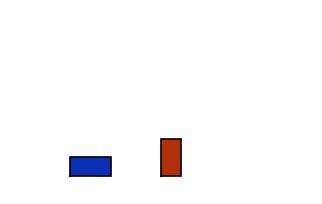

In [43]:
# place a horizontal block, move right 8 spaces, place a vertical block
render_program("h r_8 v")

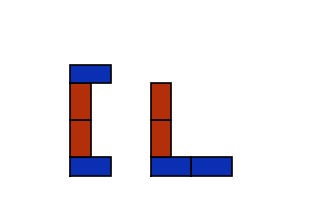

In [44]:
# render a program for one of our tower scenes
render_program("h l_1 v v r_1 h r_12 h l_4 h l_1 v v")

Here is a dictionary of programs for all of the possible scenes in our experiment.

In [45]:
manual_tower_programs = {"CL" :"h l_1 v v r_1 h r_12 h l_4 h l_1 v v",
                         "CPi": "h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h",
                         "PiC": "v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h",
                         "LPi": "h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h",
                         "LC": "h l_4 h l_1 v v r_12 h l_1 v v r_1 h",
                         "PiL": "v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v"}

## <span style="color: orange"> Exercise: familiarize yourself with tower programs </span>

To get a feel for how these programs work, try the following exercises. Also, just have a place placing blocks in different locations.

1. Render each of the towers defined in the dictionary above.
2. Render each of the towers (C, Pi, and L)

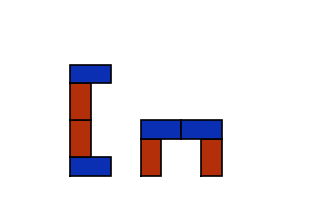

In [46]:
# render a scene program
render_program(manual_tower_programs["CPi"])

CL


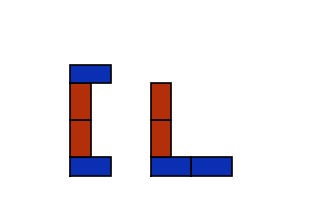

CPi


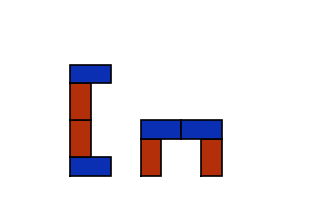

PiC


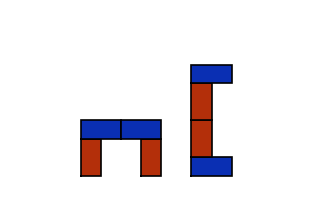

LPi


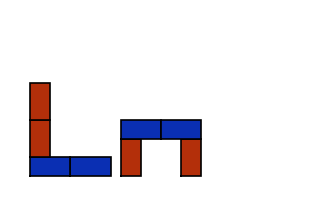

LC


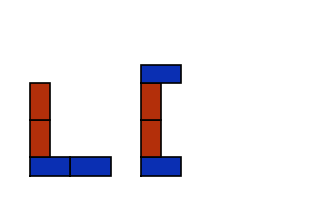

PiL


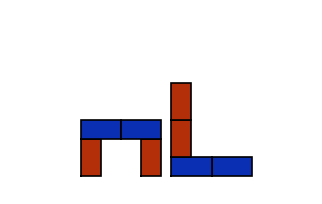

In [47]:
for key in manual_tower_programs.keys():
    print(key)
    render_program(manual_tower_programs[key])

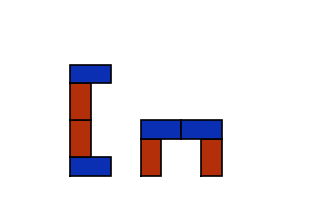

In [48]:
render_program('h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h')

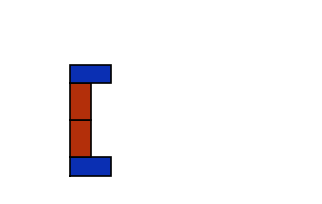

In [49]:
# render a tower
render_program('h l_1 v v r_1 h')

## Section 2: Library learning

In this section we formalize abstraction learning as the discovery of *program fragments*. Fragments can be thought of as a functional substring of a program, or subroutine. By design, the scenes we used in our experiment have several subparts that we expect will be particularly useful-- namely the 3 towers that they are constructed from.

**By augmenting the base DSL with additional tokens that correspond to program fragments, we can create news DSL that can be used to express scenes more efficiently (i.e. with fewer tokens).** For example, we represent the "CL" scene in our base DSL as `"h l_1 v v r_1 h r_12 h l_4 h l_1 v v"`. But say we had a token `"chunk_C"` that encapsulated all of the moves required to place the C-shaped tower. Then we could rewrite the scene program as `"chunk_C r_12 h l_4 h l_1 v v"` (which uses fewer tokens).

This benefit comes at the cost of storing the new abstractions in memory. This trade-off is captured by the abstraction learning algorithm, [Dreamcoder](https://arxiv.org/abs/2006.08381). Dreamcoder adds program fragments to a DSL more or less readily depending on a weighting parameter, *w*. To keep things simple, here we consider a small range of *w*s (1.5, 3.3, 9.6) that produce a reasonable range of *learning rates*. This is important, as we are using Dreamcoder to capture the *change in DSLs* across trials. As the model is exposed to more scenes (programs), fragments are added to the DSL, and scenes are able to be expressed with shorter programs. This is meant to capture the ability of participants to reason about structures larger than individual blocks.

### Loading dreamcoder libraries

To save time, we have already run library learning using the Dreamcoder algorithm for you, for a few different weight parameter values, for each participant's trial sequence.

The output is a series of DSLs-- one for each trial, for each participant, for each weight-- that (may or may not) contain additional program fragments.

These DSLs are saved in `./data/model/dsls/`.

In [50]:
# setup
ws = [1.5, 3.3, 9.6] # values of w we are considering
w_index = {1.5 : 0,
           3.3 : 2,
           9.6: 3} # positional index of w in loaded data
trials = range(1,13)
ppts = range(1,50)

In [52]:
# Read in the DSLs learned by dreamcoder

data_path = '../data/model/dsls/'

dsls = {}
trial_seqs = {}

for ppt in range(1,50):
    
    dsls[ppt] = {}
    
    # read participants' trial sequence
    with open(data_path+f"{ppt}/configs.p", "rb") as config_file:
            trial_seqs[ppt] = pickle.load(config_file)
    
    # read inferred DSLs
    for trial in range(1, 13):
        with open(data_path+f"{ppt}/{trial}.p", "rb") as input_file:
            dsls[ppt][trial] = pickle.load(input_file)

def check_values(value, valid_values, parameter_type):
    if value not in valid_values:
        raise ValueError(f'{parameter_type} must be one of the following values: {valid_values}.')
            
def read_library(ppt, trial, w = 3.2, base_dsl_only=True, sort=False):
    '''
    Returns dsl learned by dreamcoder
    '''
    check_values(ppt, range(1, 50), 'ppt')
    check_values(trial, range(1, 13), 'trial')
    check_values(w, ws, 'w')
    
    lib = [parse(str(fragment), base_dsl_only=base_dsl_only) for fragment in dsls[ppt][trial][w_index[w]]]
    
    if sort:
        lib = sorted(lib, key=lambda x: len(x.split()))
    
    return lib

Let's stick with the intermediate weight value for now (`w=3.3`).  

We can use the `read_library()` function defined above to read in the library for participant 1 (`ppt = 1`) on the first trial (`trial=1`):

In [53]:
# Read a dsl
lib = read_library(ppt = 1, 
             trial = 1,
             w = 3.3
            )
lib

[]

You should see an empty list. In trial 1, we've only seen one scene. Dreamcoder hasn't seen enough programs to identify any abstractions yet. But by their last trial (`trial=12`)...

In [54]:
# Read another dsl
lib = read_library(ppt = 1, 
             trial = 12,
             w = 3.3
            )
lib

['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h']

Dreamcoder has learned 4 program fragments! We can also visualize these:

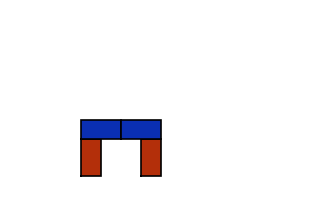

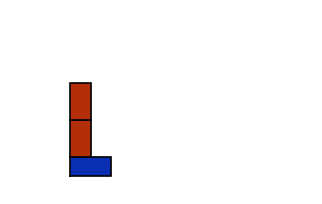

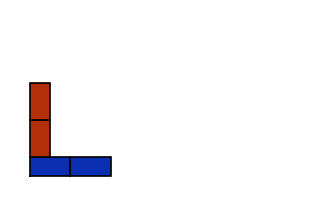

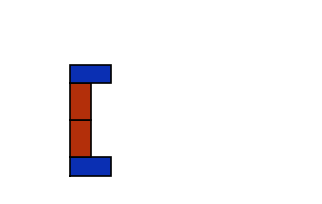

In [55]:
_ = [render_program(p) for p in lib]

This is what we hoped to see. Dreamcoder has learned program fragments for the towers that recurred across scenes. It also learned that smaller L shape. Can you work out why?

In [56]:
# def rwt(p):
# #     print(p.replace(' ','/'))
# #     print(p)
#     a = render_program(p)

# _ = [rwt(b) for bs in [p for ps in libs for p in ps] for b in bs]

## <span style="color: orange"> Exercise: explore libraries across trials</span>

We've just seen two endpoints for the library learning process for a single participant. We'd now like to get a more granular look at how libraries change over time. First try printing an entire sequence of libraries for one participant. Then, try to calculate some basic summary statistics across participants. Can you plot library size of trial? Over repetition? (the 12 trials were really split into 4 repetitions of each tower pair)

In [57]:
# Find the series of libraries for a specific weight and participant

[read_library(ppt = 1, 
             trial = trial,
             w = 3.3) for trial in range(1,13)]

[[],
 [],
 ['h l_1 v v r_1'],
 ['h l_1 v v r_1', 'v r_6 v l_5 h r_4 h'],
 ['h l_1 v v', 'v r_6 v l_5 h r_4 h', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['h l_1 v v', 'v r_6 v l_5 h r_4 h', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['h l_1 v v', 'v r_6 v l_5 h r_4 h', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['h l_1 v v', 'v r_6 v l_5 h r_4 h', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['h l_1 v v', 'v r_6 v l_5 h r_4 h', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h'],
 ['v r_6 v l_5 h r_4 h', 'h l_1 v v', 'h l_4 h l_1 v v', 'h l_1 v v r_1 h']]

In [58]:
# for p in read_library(ppt = 15, 
#              trial = 12,
#              w = 1.5,
#              base_dsl_only=True):
#     render_program(p)

In [59]:
# Find the series of libraries for a specific weight and participant
libs = [[read_library(ppt = ppt, 
             trial = trial,
             w = 1.5,
             base_dsl_only=False) for trial in range(1,13)] for ppt in range(1,50)]

<Axes: xlabel='trial', ylabel='lib_size'>

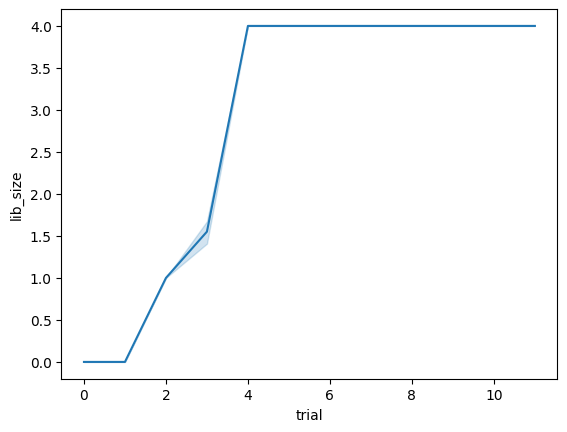

In [60]:
# plot library size
lib_sizes = [[len(read_library(ppt = ppt, 
             trial = trial,
             w = 3.3,
             base_dsl_only=False)) for trial in range(1,13)] for ppt in range(1,50)]

df = pd.DataFrame(lib_sizes)
tidy_df = df.reset_index().melt(id_vars='index', var_name='trial', value_name='lib_size')
tidy_df = tidy_df.rename(columns={'index': 'Participant'})
sns.lineplot(data=tidy_df,
             x="trial",
             y="lib_size")

In [61]:
# summarize library size across participants by trial and repetition
tidy_df["trial"] = tidy_df["trial"].astype(int)
tidy_df["trial_num"] = tidy_df["trial"] + 1
tidy_df["rep"] = tidy_df["trial_num"].apply(lambda n: np.ceil(n / 3.0))

lib_summary_by_trial = (tidy_df
                        .groupby("trial_num")["lib_size"]
                        .agg(["mean", "std", "min", "max"])
                        .reset_index())

lib_summary_by_rep = (tidy_df
                      .groupby("rep")["lib_size"]
                      .agg(["mean", "std", "min", "max"])
                      .reset_index())

lib_summary_by_trial

,trial_num,mean,std,min,max
0,1,0.00000,0.000000,0,0
1,2,0.00000,0.000000,0,0
2,3,1.00000,0.000000,1,1
3,4,1.55102,0.502545,1,2
4,5,4.00000,0.000000,4,4
5,6,4.00000,0.000000,4,4
6,7,4.00000,0.000000,4,4
7,8,4.00000,0.000000,4,4
8,9,4.00000,0.000000,4,4
9,10,4.00000,0.000000,4,4


In [62]:
lib_summary_by_rep

,rep,mean,std,min,max
0,1.0,0.333333,0.473016,0,1
1,2.0,3.183673,1.193707,1,4
2,3.0,4.000000,0.000000,4,4
3,4.0,4.000000,0.000000,4,4


,ppt,trial,chunk
0,5,3,chunk_8b
1,5,4,chunk_8
2,5,5,chunk_C
3,5,5,chunk_L
4,5,5,chunk_Pi


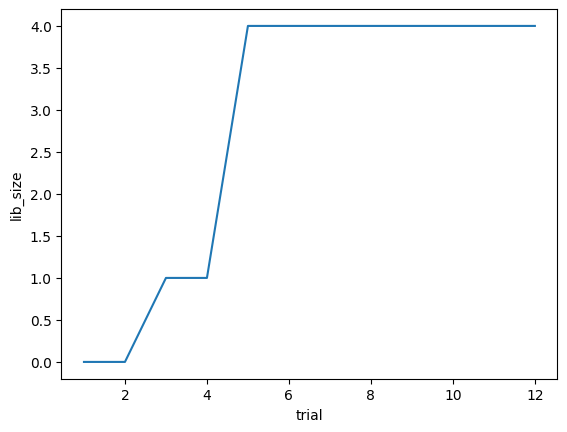

In [90]:
# explore libraries across trials for a single participant (ppt = PLOT_PPT_ID) at w = 3.3
PLOT_PPT_ID=5

ppt_libs_by_trial = [read_library(ppt=PLOT_PPT_ID,
                                  trial=trial,
                                  w=3.3,
                                  base_dsl_only=False)
                      for trial in range(1, 13)]

ppt_lib_sizes = [len(lib) for lib in ppt_libs_by_trial]

ppt_trial_df = pd.DataFrame({
    "trial": list(range(1, 13)),
    "lib_size": ppt_lib_sizes
})

sns.lineplot(data=ppt_trial_df,
             x="trial",
             y="lib_size")

# identify newly learned chunks for the selected participant over trials
ppt_new_chunk_records = []
seen_chunks = set()

for trial_index, fragments in enumerate(ppt_libs_by_trial, start=1):
    current_chunks = set(fragments)
    new_chunks = sorted(current_chunks.difference(seen_chunks))
    for chunk in new_chunks:
        ppt_new_chunk_records.append({
            "ppt": PLOT_PPT_ID,
            "trial": trial_index,
            "chunk": chunk
        })
    seen_chunks.update(current_chunks)

ppt_new_chunks_df = pd.DataFrame(ppt_new_chunk_records)
ppt_new_chunks_df

### Exploring library contents

We're currently displaying each fragment as a program in the base DSL, but the whole point of learning fragments is that you can express them as a single token.

If we were fully automating this process, we might use an ID to label each learned fragment. In this example, only a handful of fragments are learned. This makes it possible to give each fragment a more helpful, human-readable name. If we change `base_dsl_only` to `False` then we can give these learned fragments helpful names (taken from a look-up table we've manually coded).

In [63]:
read_library(ppt = 1, 
             trial = 12,
             w = 1.5,
             base_dsl_only=False)

['chunk_Pi', 'chunk_8', 'chunk_L', 'chunk_C', 'chunk_CPi', 'chunk_PiC']

We refer to all these learned abstractions as "chunks". 

- `chunk_n`, where n is a number (and sometimes also a letter) are subtower expressions (capturing several block placements)
- `chunk_Pi`, `chunk_C` and `chunk_L`, are distinct block towers. 
- `chunk_CPi` (and other chunks with two of C, L, and Pi) are single abstractions that capture the entire scene.

## <span style="color: orange"> Exercise: compare libraries across different weights</span>

First, see how library size and contents changes with different values of w. 

Next, see if you can get a sense of how the *content* of a library changes across weights. Is it the case that the same chunks are learned but at different rates, or are different kinds of chunks (at different abstraction levels) learned when the weighting parameter is diffferent?

In [64]:
# Find the series of libraries for a specific weight and participant
libs = [[read_library(ppt = ppt, 
             trial = trial,
             w = 1.5,
             base_dsl_only=False) for trial in range(1,13)] for ppt in range(1,50)]

In [65]:
pd.Series([y for ys in [x for xs in libs for x in xs] for y in ys]).value_counts()

chunk_Pi     510
chunk_L      505
chunk_C      490
chunk_8      428
chunk_CPi    248
chunk_LPi    145
chunk_8b     105
chunk_PiC    105
chunk_PiL     20
chunk_CL      18
chunk_6b      17
chunk_1        6
Name: count, dtype: int64

<Axes: xlabel='trial', ylabel='lib_size'>

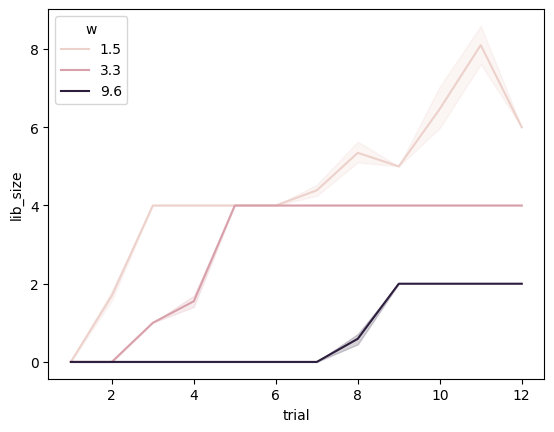

In [66]:
# compare library sizes across different weights
lib_sizes_by_w = []
for w_val in ws:
    for ppt in ppts:
        for trial in trials:
            size = len(read_library(ppt=ppt,
                                    trial=trial,
                                    w=w_val,
                                    base_dsl_only=False))
            lib_sizes_by_w.append({"w": w_val,
                                   "ppt": ppt,
                                   "trial": trial,
                                   "lib_size": size})

lib_sizes_by_w_df = pd.DataFrame(lib_sizes_by_w)
sns.lineplot(data=lib_sizes_by_w_df,
             x="trial",
             y="lib_size",
             hue="w")

In [79]:
# explore which chunks are learned under each weight
chunk_freq_by_w = {}
for w_val in ws:
    fragments = [fragment
                 for ppt in ppts
                 for trial in trials
                 for fragment in read_library(ppt=ppt,
                                              trial=trial,
                                              w=w_val,
                                              base_dsl_only=False)]
    if len(fragments) > 0:
        chunk_freq_by_w[w_val] = pd.Series(fragments).value_counts()
    else:
        chunk_freq_by_w[w_val] = pd.Series(dtype="int64")


In [80]:
chunk_freq_by_w

{1.5: chunk_Pi     510
 chunk_L      505
 chunk_C      490
 chunk_8      428
 chunk_CPi    248
 chunk_LPi    145
 chunk_8b     105
 chunk_PiC    105
 chunk_PiL     20
 chunk_CL      18
 chunk_6b      17
 chunk_1        6
 Name: count, dtype: int64,
 3.3: chunk_8     425
 chunk_Pi    419
 chunk_L     392
 chunk_C     392
 chunk_8b     65
 Name: count, dtype: int64,
 9.6: chunk_8     225
 chunk_9     127
 chunk_Pi     69
 Name: count, dtype: int64}

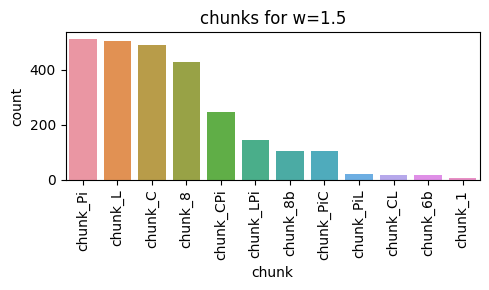

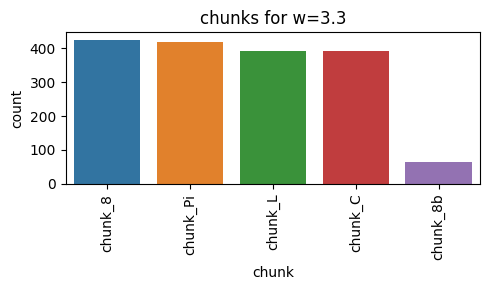

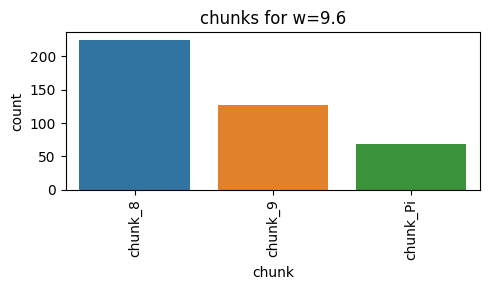

In [93]:
# visualize top chunks for each weight as bar plots

for w_val in ws:
    top_chunks = chunk_freq_by_w[w_val].reset_index()
    if top_chunks.empty:
        continue
    top_chunks.columns = ["chunk", "count"]
    plt.figure(figsize=(5, 3))
    sns.barplot(data=top_chunks,
                x="chunk",
                y="count")
    plt.title("chunks for w={}".format(w_val))
    plt.xticks(rotation=90)
    plt.tight_layout()

## Section 3: Representing scenes more concisely with refactored programs

Now we have inferred the libraries of part concepts available to each participant in each trial. These part concepts, or program fragments, allow each scene program to be expressed more efficiently. In the next notebook, the model makes a decision about whether to use the most efficient program available to it, or play it safe and use lower-level language (about individual blocks). Before we get there, we first need to find these efficient programs.

How to search for programs given a DSL is an interesting research question in itself. Here, however, our focus is on how people choose between more or less efficient ways of expressing a concept, given uncertainty about what their partner will understand. For our purposes, we just need to select the single most efficient program that represents each scene. Fortunately for us, Dreamcoder libraries uniquely determine this most efficient programs: we simply swap in the learned abstractions from our DSLs through string-matching. The `refactor_programs()` function does this refactoring for you.

From here on out we're going to stick with `w=3.3`, as we found that this learning rate led to abstractions that most closely mirrored the expressions that people used across the experiment.

In [68]:
w = 3.3 # stick with 3.3 from here on
w_position = w_index[w]

In [69]:
from refactorPrograms import * 

In [70]:
# refactor the programs
refactor_programs(dsls,
                  trial_seqs,
                  w_position = w_position)

Programs saved in ../data/model/your_programs/programs_ppt_[ppt].json


In [71]:
# inspect programs

ppt = 1

ppt_data = pd.read_json('../data/model/your_programs/programs_ppt_{}.json'.format(ppt))
ppt_data

,ppt,trial_num,towers,dsl_lambda,chunks,dsl,min_program,programs_with_length
0,1,1,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,{'h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h': 14}
1,1,2,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_4 h l_1 v v r_12 h l_1 v v r_1 h,{'h l_4 h l_1 v v r_12 h l_1 v v r_1 h': 13}
2,1,3,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,{'h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h': 14}
3,1,4,PiC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",[chunk_8b],"[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",v r_6 v l_5 h r_4 h r_7 chunk_8b h,"{'v r_6 v l_5 h r_4 h r_7 chunk_8b h': 10, 'v ..."
4,1,5,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8b, chunk_Pi]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_8b h r_12 h l_4 h l_1 v v,"{'chunk_8b h r_12 h l_4 h l_1 v v': 9, 'h l_1 ..."
5,1,6,PiL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_Pi r_9 chunk_L,"{'chunk_Pi r_9 chunk_L': 3, 'v r_6 v l_5 h r_4..."
6,1,7,LC,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_12 chunk_C,"{'chunk_L r_12 chunk_C': 3, 'h l_4 h l_1 v v r..."
7,1,8,CPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_6 chunk_Pi,"{'chunk_C r_6 chunk_Pi': 3, 'chunk_C r_6 v r_6..."
8,1,9,LPi,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_8, chunk_Pi, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_L r_9 chunk_Pi,"{'chunk_L r_9 chunk_Pi': 3, 'chunk_L r_9 v r_6..."
9,1,10,CL,"[2x1, 1x2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...","[chunk_Pi, chunk_8, chunk_L, chunk_C]","[h, v, l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7,...",chunk_C r_12 chunk_L,"{'chunk_C r_12 chunk_L': 3, 'chunk_C r_12 h l_..."


## <span style="color: orange"> Exercise: Explore how programs change across trials</span>

We now have, for each participant, the most concise way of expressing each scene program (min_program). Take a look at these programs and try to make sense of them. Do they get longer or shorter over trials?

**Hint**: This exploration is analagous to the message length analysis in the previous notebook.

In [72]:
ppt = 1

all_program_data = pd.DataFrame()

for ppt in range(1,50):

    with open("../data/model/your_programs/programs_ppt_" + str(ppt) + ".json", "r") as read_file:
        trial_data = pd.read_json(read_file)
        all_program_data = pd.concat([all_program_data, trial_data], ignore_index=True)

<Axes: xlabel='trial_num', ylabel='min_prog_length'>

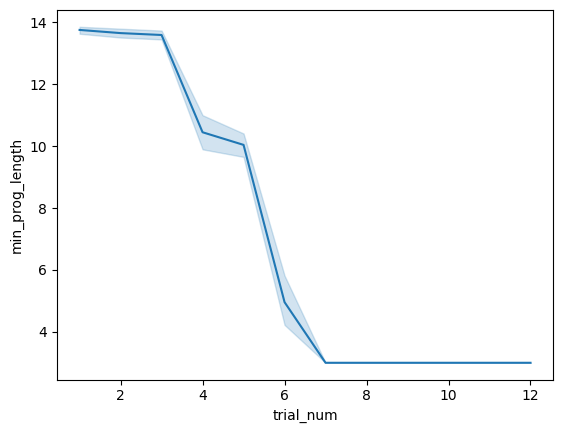

In [73]:
all_program_data['min_prog_length'] = all_program_data.min_program.apply(lambda x: len(x.split(' ')))

sns.lineplot(data = all_program_data,
         x = 'trial_num',
         y = 'min_prog_length')

<Axes: xlabel='rep', ylabel='min_prog_length'>

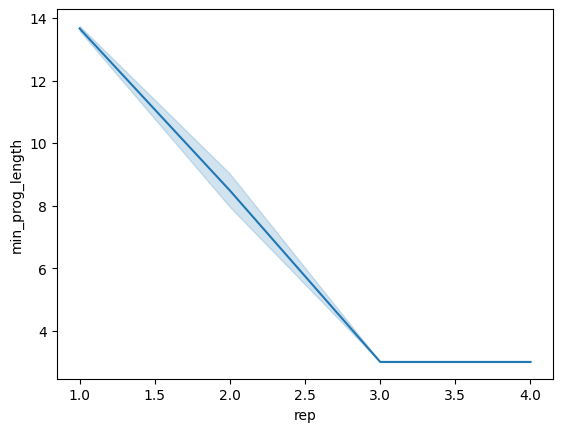

In [74]:
all_program_data['rep'] = all_program_data.trial_num.apply(lambda n: np.ceil(n/3))


sns.lineplot(data = all_program_data,
         x = 'rep',
         y = 'min_prog_length')

### Summary

We've seen how we can model the learning of part concepts as adding program fragments to a library. We've seen that doing so allows us to express a scene program more concisely. Those keen-eyed among you may have spotted that `refactor_programs()` also outputted another variable `programs_with_length`. This contains a small range of programs, derived from the shortest program, that use more or less of these fragments, and hence **express the same program with a range of levels of concision**. More concise programs use more abstractions. In the [final notebook](/notebooks/conventions.ipynb), we explore how people might weigh this concision against another factor-- informativity.

Woohoo! Notebook 2 complete! Have a stretch, go for a walk, drink some water.

